# Pregunta 6

(2 puntos) La imagen Ex3Preg6(a).tif muestra una imagen tomada con un microscopio de cultivo de bacterias identificadas por los círculos intensos:

a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

c. (1 punto) Continuando con la imagen anterior. Cuente y etiquete cuantos objetos de la segmentación pueden considerarse 2 células agrupadas, y cuantos y cuales más de 2 células.

In [1]:
# Functional programing tools : 
from functools import partial, reduce

# Visualisation : 
import matplotlib.pyplot as plt
import matplotlib.image as pim
import matplotlib.patches as mpatches
import seaborn as sns

# Data tools :
import numpy as np
import pandas as pd

# Image processing : 
import cv2 as cv
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# Machine Learning :
from sklearn.cluster import KMeans

# Jupyter reimport utils :
import importlib

In [2]:
# Custom :
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs

import utils
importlib.reload(utils)
import utils

In [3]:
#plt.style.available

In [4]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (10, 5)

In [6]:
img   = cv.imread('imagenes/Ex3Preg6(a).tif', cv.IMREAD_GRAYSCALE)
color = cv.cvtColor(img, cv.COLOR_GRAY2RGB) # Color copy, to draw colored circles

## a. (0.5 puntos) Usando una técnica de umbralización global, segmente la imagen y muestre el resultado de la segmetnación.

In [7]:
intensities = pd.core.frame.DataFrame(dict(intensity=img.flatten()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c252e0c90>]],
      dtype=object)

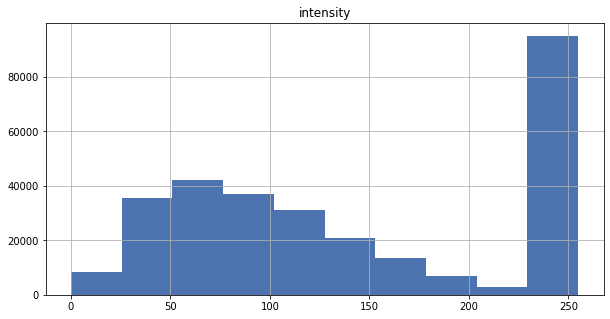

In [8]:
intensities.hist()

In [9]:
kmeans = KMeans(n_clusters=2, random_state=0, verbose=False).fit(intensities)
K = kmeans.cluster_centers_.mean()

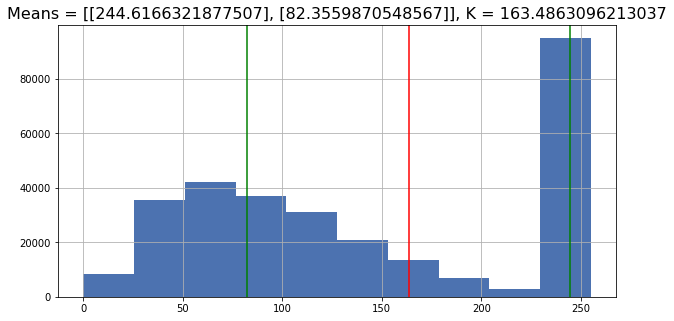

In [10]:
intensities.hist()
plt.axvline(K, color='r')
list(map(lambda x: plt.axvline(x, color='g'), kmeans.cluster_centers_))
_ = plt.title(f"Means = {kmeans.cluster_centers_.tolist()}, K = {K}", size=16)

In [11]:
thresh1 = cv.threshold(img, K, 255, cv.THRESH_BINARY)[1]

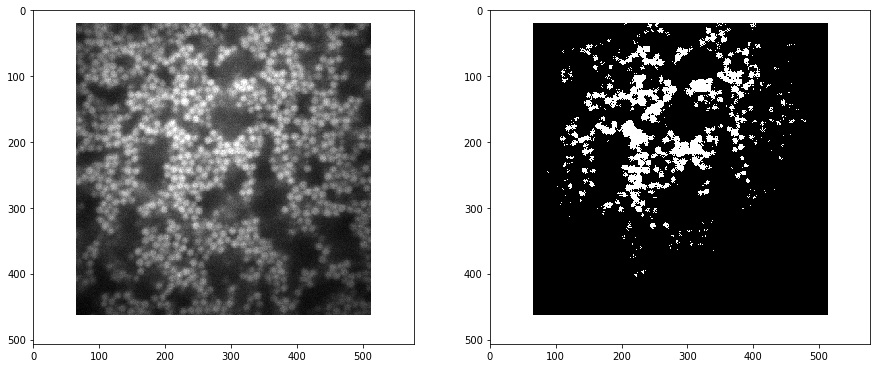

In [12]:
utils.side_by_side(img, thresh1)

Como podemos ver, una técinca de umbralización estándar como k-medias móviles, con dos medias, da resultados muy pobres.

In [13]:
otsu1 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

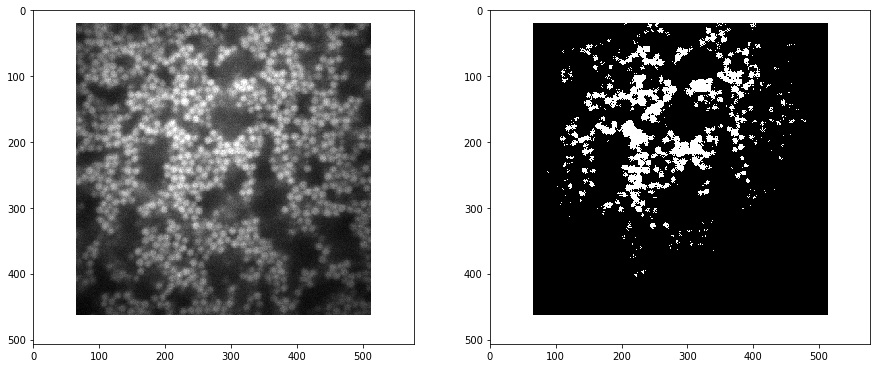

In [14]:
utils.side_by_side(img, otsu1)

El algoritmo de Otsu no logra mejorar mucho la segmentación (esto era de esperarse dado que el histograma original era claramente bimodal). 

In [15]:
gblur = cv.GaussianBlur(img,(3,3),0)
otsu2 = cv.threshold(gblur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

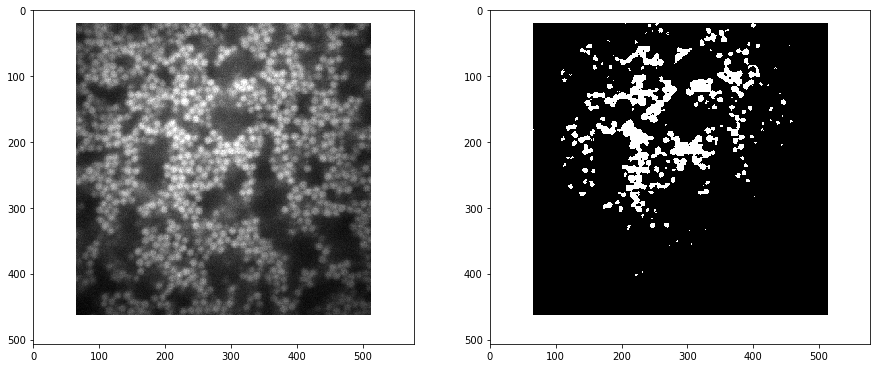

In [16]:
utils.side_by_side(img, otsu2)

El algoritmo de Otsu no logra mejorar mucho la segmentación aún en combinación con un suavizado Gaussiano.

In [17]:
img_blur = cv.medianBlur(img, 5)
circles = cv.HoughCircles(img_blur, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=7)

In [18]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv.circle(img, (i[0], i[1]), i[2], (0, 0, 255), 2)

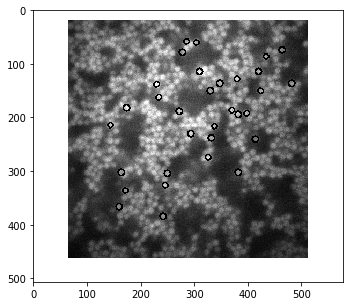

In [19]:
plt.imshow(img, cmap='gray')

Al ver que las células tenían una apariencia más o menos circular, parecía una buena idea usar una transformada de Hough para buscar los círculos de la imagen, pero esto entregó resultados muy pobres. Tal vez esto podría funcionar con la imagen binaria.

## b. (0.5 puntos) A la imagenoriginal se le aplicó una umbralización con valores locales yal resultado se le realizó una apertura morbológica obteniendo la imagen Ex3Preg6(b).tif. Usando esta imagen,cuente y etiquete cuantos objetos de la segmentación pueden considerarse células independientes. 

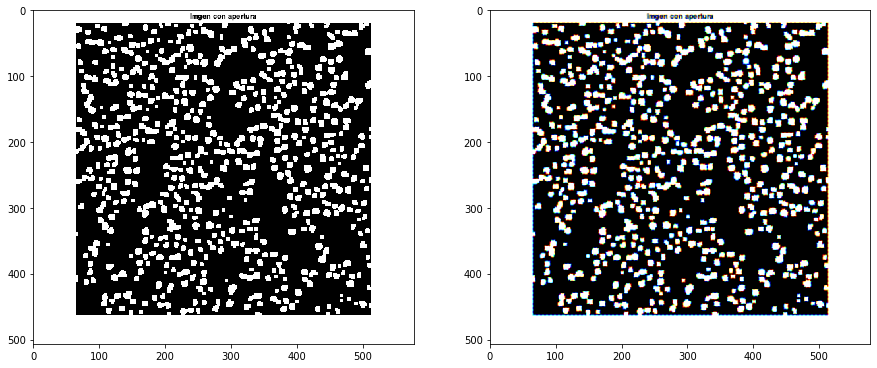

In [20]:
imgb  = cv.imread('imagenes/Ex3Preg6(b).tif', cv.IMREAD_GRAYSCALE)
imgbc = cv.cvtColor(imgb, cv.COLOR_BAYER_GB2RGB)
utils.side_by_side(imgb, imgbc)

### Primera aproximación :
El uso de la transformada de Hough para círculos, no para líneas. Al ver la imagen, uno podría pensar que un círculo es una buena aproximación de la forma de una célula, por lo tanto los cículos encontrados por una transformada de Hough serían las células que buscamos identificar, caracterizar y contabilizar

In [21]:
circles = cv.HoughCircles(imgb, cv.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=5, maxRadius=15)

In [22]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv.circle(imgbc, (i[0], i[1]), i[2], (155, 0, 0), 2)

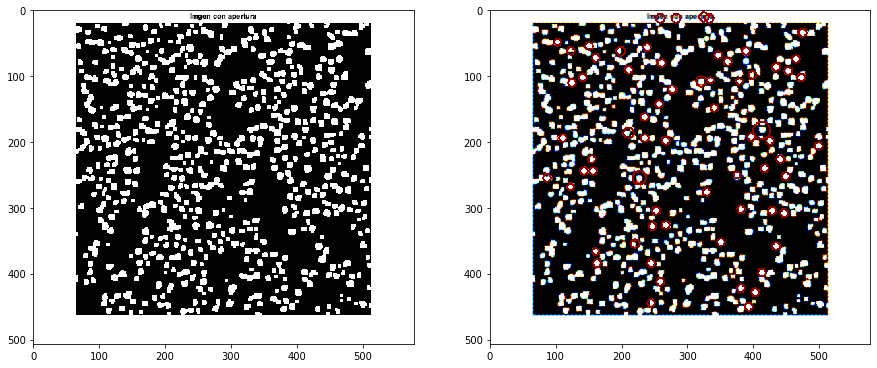

In [23]:
utils.side_by_side(imgb, imgbc)

Aquí podemos ver que aunque la imagen principal carece de falsos positivos (es decir todos los círculos dibujados dentro de la región útil de la imagen contienen una célula) el **número de falsos negativos es altísimo** : sólo una pequeña parte de las células observadas fueron identificadas por ```cv.HoughCircles()```. 

Esto nos indica que tal vez las células no se asemejan tanto a un círculo. Por esta razón, no se explorará más a fondo esta vía de acción. Cabe mencionar que la transformada encuentra círculos en el texto de encabezado : **Imagen con apertura**. Por esta razón, en delante se trabajará con otra imagen recortada a mano para excluir este texto que podría causar problemas en la segmentación más adelante.

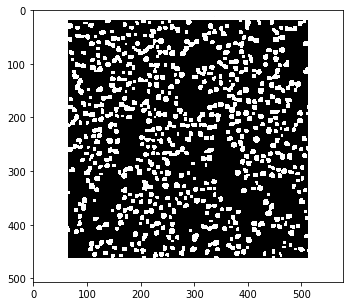

In [28]:
imgb2  = cv.imread('imagenes/Ex3Preg6(b)3.tif', cv.IMREAD_GRAYSCALE)
plt.imshow(imgb2, cmap='gray')

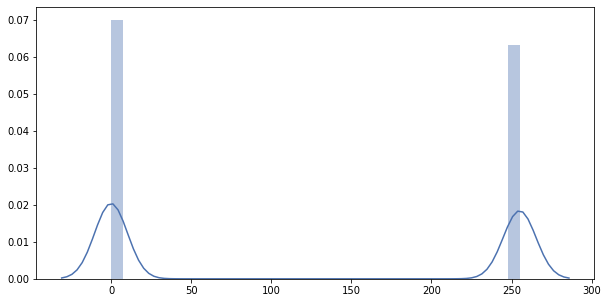

In [34]:
sns.distplot(imgb2.flatten())

Imagen claramente binaria.

475


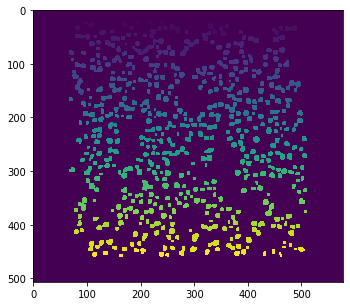

In [29]:
label_image, n_objs = label(imgb2, return_num=True)
plt.imshow(label_image)
print(n_objs)

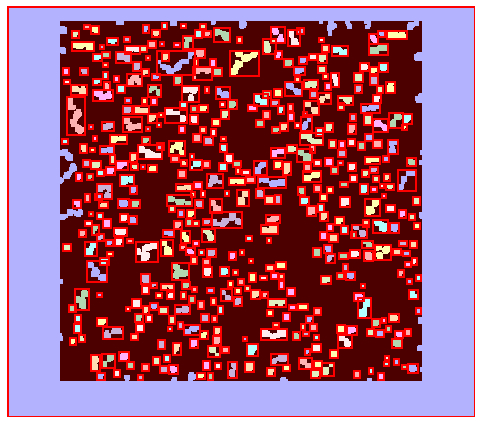

In [35]:
image_label_overlay = label2rgb(label_image, image=imgb2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 10:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

# Extra

477


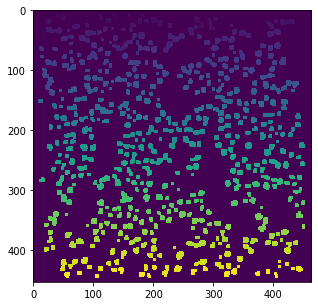

In [26]:
label_image, n_objs = label(imgb2, return_num=True)
plt.imshow(label_image)
print(n_objs)

In [ ]:
cleared = clear_border()
plt.imshow(cleared)

# Scikit-Image example :

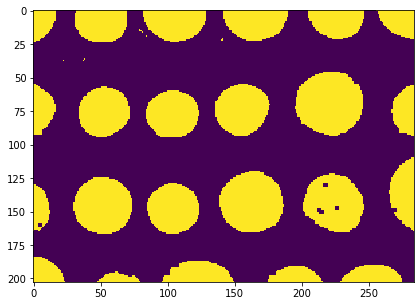

In [151]:
image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))
plt.imshow(bw)

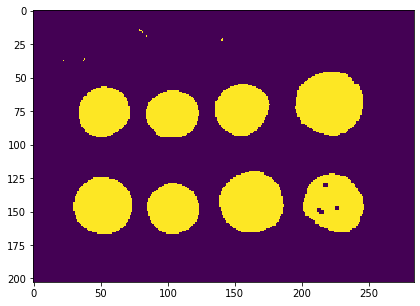

In [152]:
# remove artifacts connected to image border
cleared = clear_border(bw)
plt.imshow(cleared)

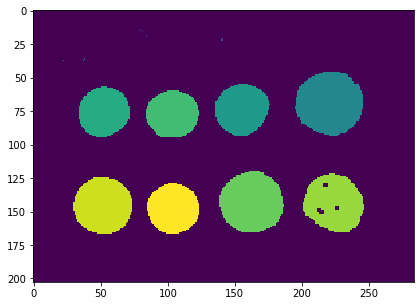

In [154]:
# label image regions
label_image = label(cleared)
plt.imshow(label_image)

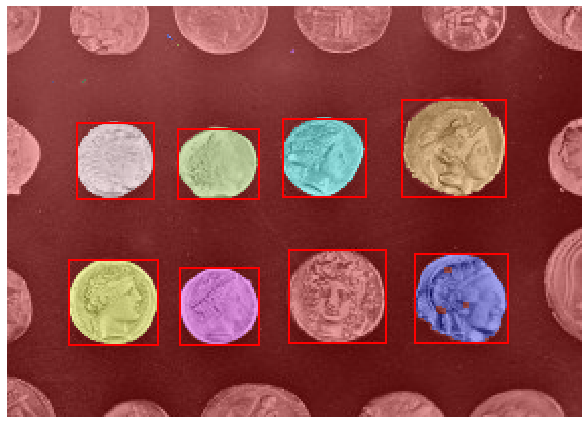

In [155]:
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [147]:
#help(cv2.HoughCircles)

In [148]:
#help(cv2.cvtColor)

In [158]:
help(label)

Help on function label in module skimage.measure._label:

label(input, neighbors=None, background=None, return_num=False, connectivity=None)
    Label connected regions of an integer array.
    
    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::
    
      1-connectivity     2-connectivity     diagonal connection close-up
    
           [ ]           [ ]  [ ]  [ ]             [ ]
            |               \  |  /                 |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]        [x]--[ ]
            |               /  |  \             hop 1
           [ ]           [ ]  [ ]  [ ]
    
    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connect